### BUILDING MICROGRAD
##### INTRO TO NEURAL NETS

In [70]:
# MICROGRAD - AUTO GRADIENT ENGINE (MICRO GRADIENT ENGINE)
# Implements Backpropagation

In [71]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [72]:
def f(x):
    return 3*x**2 - 4*x +5

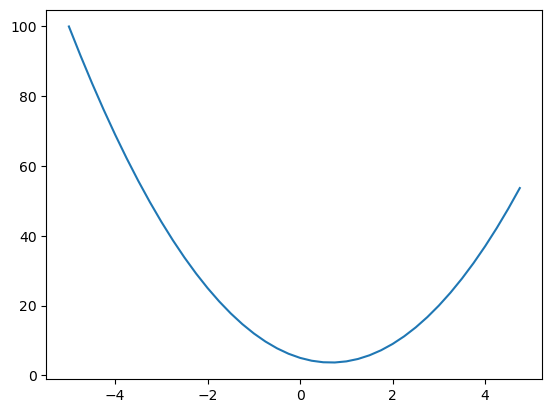

In [73]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [74]:
### DERIVATIVE = RATE AT WHICH Y INCREASES WITH X

In [75]:
h=0.001
x=3
(f(x+h)-f(x))/h

14.00300000000243

In [76]:
a = 2
b = -3
c = 10
d = a*b+c
print(d)

4


In [77]:
h=0.0001
b = -3
c = 10
d1 = a*b+c
a += h 
d2 = a*b+c
print('d1',d1)
print('d2',d2)
print('slope',(d2-d1)/h)

d1 4
d2 3.999699999999999
slope -3.000000000010772


In [78]:
h=0.0001
b = -3
c = 10
d1 = a*b+c
b += h 
d2 = a*b+c
print('d1',d1)
print('d2',d2)
print('slope',(d2-d1)/h)

d1 3.999699999999999
d2 3.99990001
slope 2.0001000000124947


In [79]:
h=0.0001
b = -3
c = 10
d1 = a*b+c
c += h 
d2 = a*b+c
print('d1',d1)
print('d2',d2)
print('slope',(d2-d1)/h)

d1 3.999699999999999
d2 3.9997999999999987
slope 0.9999999999976694


In [80]:
class Value:
    """
    Value class for automatic differentiation (Micrograd-style).

    This class represents a scalar value in a computation graph, along with its gradient,
    the operation that produced it, and its parents (inputs). It supports basic arithmetic
    operations and can compute gradients via reverse-mode autodiff (backpropagation).

    Attributes:
        data (float): The scalar value.
        grad (float): The gradient of some final output w.r.t. this value.
        _backward (function): Function to compute the local gradient and propagate it to parents.
        _prev (set): Set of parent Value objects (inputs to the operation).
        _op (str): The operation that produced this value (for graph visualization/debugging).
        label (str): Optional label for visualization.
    """

    def __init__(self, data, _children=(), _op='', label=''):
        """
        Initialize a Value node.

        Args:
            data (float): The scalar value.
            _children (tuple): Parent nodes (inputs to the operation).
            _op (str): The operation that produced this node.
            label (str): Optional label for visualization.
        """
        self.data = data                  # The scalar value
        self.grad = 0.0                   # The gradient (d output / d self)
        self._backward = lambda: None     # Function to propagate gradients to parents
        self._prev = set(_children)       # Parents in the computation graph
        self._op = _op                    # Operation that produced this node
        self.label = label                # Optional label for visualization

    def __repr__(self):
        """Return a string representation of the Value object."""
        return f"Value(data={self.data})"

    def __add__(self, other):
        """
        Addition operation: supports Value + Value or Value + scalar.

        Args:
            other (Value or float): The other Value or scalar to add.

        Returns:
            Value: The result of the addition.
        """
        # Support addition with scalars or other Value objects
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            # d(out)/d(self) = 1, d(out)/d(other) = 1
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        """
        Multiplication operation: supports Value * Value or Value * scalar.

        Args:
            other (Value or float): The other Value or scalar to multiply.

        Returns:
            Value: The result of the multiplication.
        """
        # Support multiplication with scalars or other Value objects
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            # d(out)/d(self) = other.data, d(out)/d(other) = self.data
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        """
        Power operation (only supports int/float exponents).

        Args:
            other (int or float): The exponent.

        Returns:
            Value: The result of the power operation.
        """
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            # d(out)/d(self) = other * self.data**(other-1)
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):
        """
        Right multiplication to support scalar * Value.

        Args:
            other (float): The scalar multiplier.

        Returns:
            Value: The result of the multiplication.
        """
        return self * other

    def __truediv__(self, other):
        """
        Division operation: self / other = self * (other ** -1).

        Args:
            other (Value or float): The denominator.

        Returns:
            Value: The result of the division.
        """
        return self * other ** -1

    def __neg__(self):
        """
        Negation operation: -self.

        Returns:
            Value: The negated value.
        """
        return self * -1

    def __sub__(self, other):
        """
        Subtraction operation: self - other = self + (-other).

        Args:
            other (Value or float): The value to subtract.

        Returns:
            Value: The result of the subtraction.
        """
        return self + (-other)

    def __radd__(self, other):
        """
        Right addition to support scalar + Value.

        Args:
            other (float): The scalar to add.

        Returns:
            Value: The result of the addition.
        """
        return self + other

    def tanh(self):
        """
        Hyperbolic tangent activation function.

        Returns:
            Value: The result of applying tanh to this Value.
        """
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)  # tanh(x)
        out = Value(t, (self,), 'tanh')

        def _backward():
            # d(tanh(x))/dx = 1 - tanh(x)^2
            self.grad += (1 - t ** 2) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        """
        Exponential function.

        Returns:
            Value: The result of applying exp to this Value.
        """
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            # d(exp(x))/dx = exp(x)
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        """
        Computes the gradients of all nodes in the computation graph
        with respect to this Value (usually the output/loss node).
        """
        topo = []           # List for topological order
        visited = set()     # Set to avoid revisiting nodes

        def build_topo(v):
            # Recursively build topological order of nodes
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0     # Seed gradient (d self / d self = 1)
        for node in reversed(topo):
            node._backward()

In [81]:
from graphviz import Digraph

def trace(root):
    """
    Build a set of all nodes and edges in a computation graph starting from the root node.

    Args:
        root (Value): The root node of the computation graph.

    Returns:
        nodes (set): Set of all Value nodes in the graph.
        edges (set): Set of (parent, child) edges in the graph.
    """
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)  # Add the node to the set of nodes
            for child in v._prev:
                edges.add((child, v))  # Add an edge from each parent (child) to this node
                build(child)           # Recursively build the graph for parent nodes
    build(root)
    return nodes, edges

def draw_dot(root):
    """
    Visualize the computation graph using Graphviz, starting from the root node.

    Args:
        root (Value): The root node of the computation graph.

    Returns:
        dot (Digraph): A Graphviz Digraph object representing the computation graph.
    """
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)  # Get all nodes and edges in the graph
    for n in nodes:
        uid = str(id(n))
        # For any value in the graph, create a rectangular ('record') node showing label, data, and grad
        dot.node(
            name=uid,
            label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad),
            shape='record'
        )
        if n._op:
            # If this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # Connect the op node to the value node
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # Connect each parent node to the op node of its child
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot  # Returns a Graphviz

In [82]:
a = Value(2.0,label = 'a')
b = Value(-3.0,label = 'b')
c = Value(10.0,label = 'c')
e = a * b; e.label = 'e' 
d= e + c; d.label = 'd'
f = Value(-2.0,label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

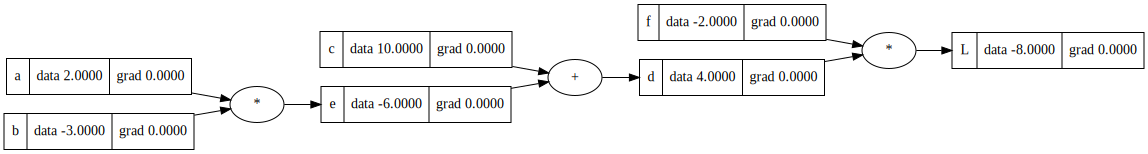

In [83]:
draw_dot(L)

### BACK PROPOGATE THROUGH NEURONS

In [84]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

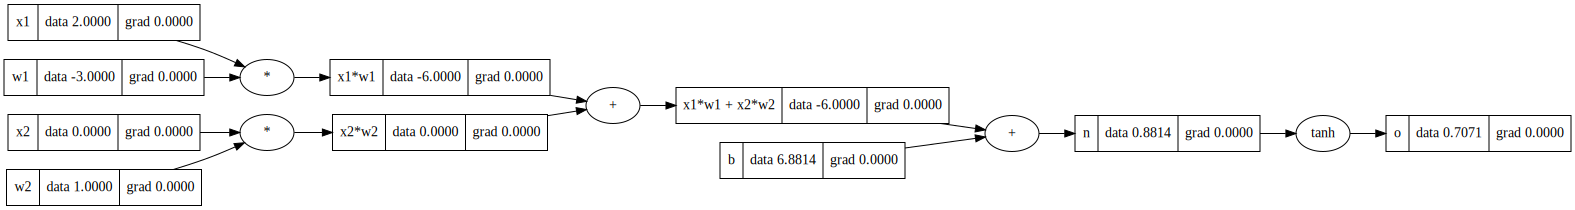

In [85]:
draw_dot(o)

In [86]:
o.grad = 1.0

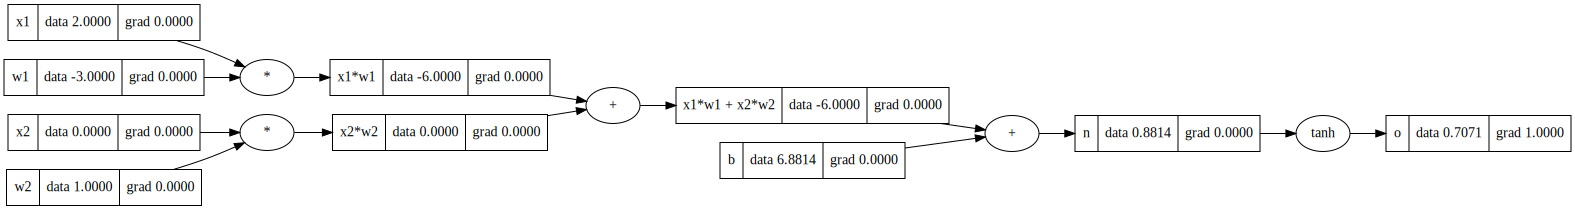

In [87]:
draw_dot(o)

In [88]:
o._backward()

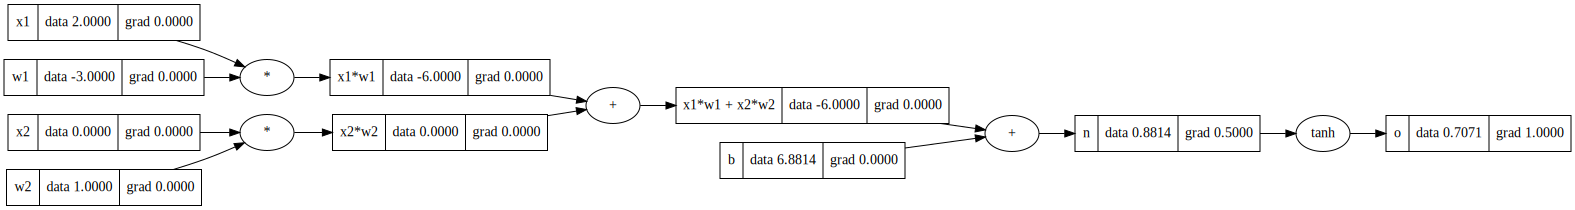

In [89]:
draw_dot(o)

In [90]:
n._backward()

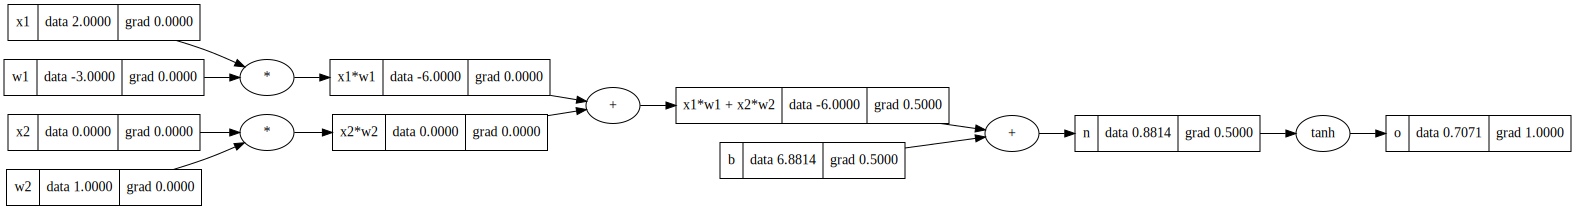

In [91]:
draw_dot(o)

In [92]:
b._backward()

In [93]:
x1w1x2w2._backward()

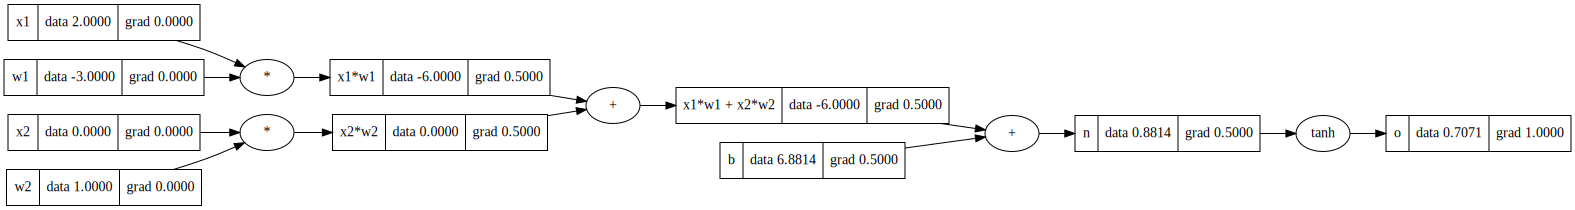

In [94]:
draw_dot(o)

In [95]:
x1w1._backward()
x2w2._backward()

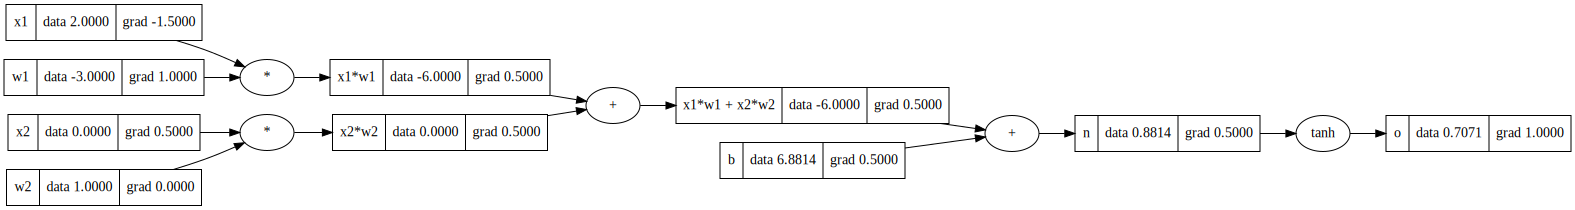

In [96]:
draw_dot(o)

In [97]:
# Build a topological ordering of the computation graph for backpropagation

topo = []           # List to store nodes in topological order
visited = set()     # Set to keep track of visited nodes

def build_topo(v):
    # Recursively visit all parents (inputs) of node v
    if v not in visited:
        visited.add(v)                # Mark node as visited
        for child in v._prev:         # Visit all parent nodes
            build_topo(child)
        topo.append(v)                # Add node to topo list after its parents

build_topo(o)        # Start from output node 'o'
topo                 # 'topo' now contains nodes in

[Value(data=6.881373587019543),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [98]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

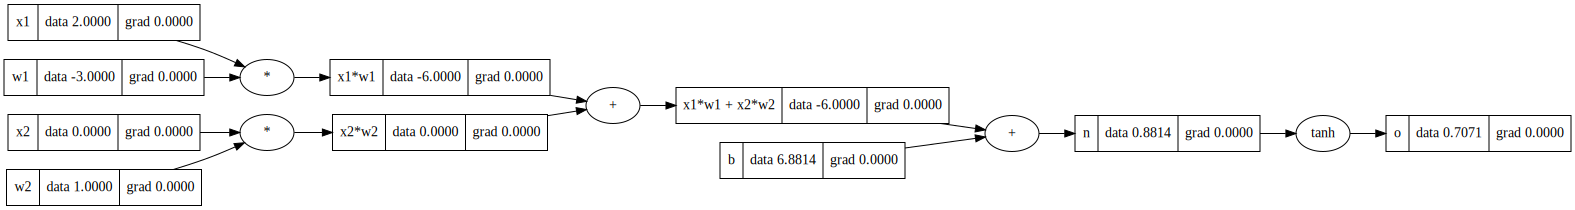

In [99]:
draw_dot(o)

In [100]:
# this is the topological order for the graph that we can use to backpropagate

topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

#gradient for this is going to be 1.0 as this is the final output node (self derivative)
o.grad = 1.0

#we are doing reverse back propagation here in the graph using chain rule
for node in reversed(topo):
    node._backward()

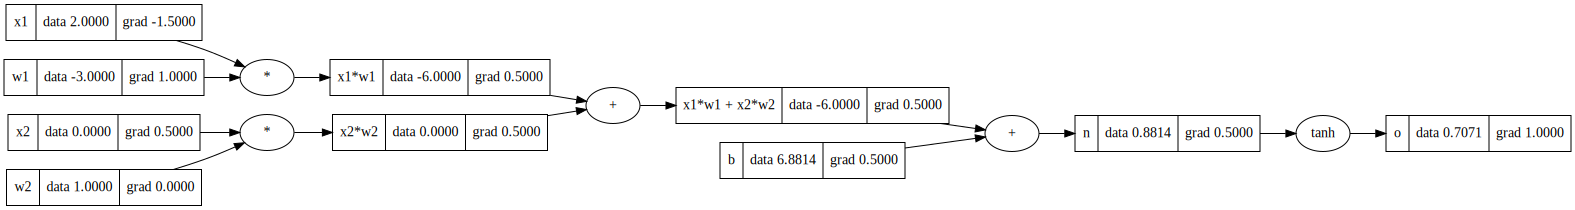

In [101]:
draw_dot(o)

### NEW VALUE CLASS

In [102]:
class Value:
    """
    Value class for automatic differentiation (Micrograd-style).

    This class represents a scalar value in a computation graph, along with its gradient,
    the operation that produced it, and its parents (inputs). It supports basic arithmetic
    operations and can compute gradients via reverse-mode autodiff (backpropagation).

    Attributes:
        data (float): The scalar value.
        grad (float): The gradient of some final output w.r.t. this value.
        _backward (function): Function to compute the local gradient and propagate it to parents.
        _prev (set): Set of parent Value objects (inputs to the operation).
        _op (str): The operation that produced this value (for graph visualization/debugging).
        label (str): Optional label for visualization.
    """

    def __init__(self, data, _children=(), _op='', label=''):
        """
        Initialize a Value node.

        Args:
            data (float): The scalar value.
            _children (tuple): Parent nodes (inputs to the operation).
            _op (str): The operation that produced this node.
            label (str): Optional label for visualization.
        """
        self.data = data                  # The scalar value
        self.grad = 0.0                   # The gradient (d output / d self)
        self._backward = lambda: None     # Function to propagate gradients to parents
        self._prev = set(_children)       # Parents in the computation graph
        self._op = _op                    # Operation that produced this node
        self.label = label                # Optional label for visualization

    def __repr__(self):
        """Return a string representation of the Value object."""
        return f"Value(data={self.data})"

    def __add__(self, other):
        """
        Addition operation: supports Value + Value or Value + scalar.

        Args:
            other (Value or float): The other Value or scalar to add.

        Returns:
            Value: The result of the addition.
        """
        # Support addition with scalars or other Value objects
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            # d(out)/d(self) = 1, d(out)/d(other) = 1
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        """
        Multiplication operation: supports Value * Value or Value * scalar.

        Args:
            other (Value or float): The other Value or scalar to multiply.

        Returns:
            Value: The result of the multiplication.
        """
        # Support multiplication with scalars or other Value objects
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            # d(out)/d(self) = other.data, d(out)/d(other) = self.data
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        """
        Power operation (only supports int/float exponents).

        Args:
            other (int or float): The exponent.

        Returns:
            Value: The result of the power operation.
        """
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            # d(out)/d(self) = other * self.data**(other-1)
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):
        """
        Right multiplication to support scalar * Value.

        Args:
            other (float): The scalar multiplier.

        Returns:
            Value: The result of the multiplication.
        """
        return self * other

    def __truediv__(self, other):
        """
        Division operation: self / other = self * (other ** -1).

        Args:
            other (Value or float): The denominator.

        Returns:
            Value: The result of the division.
        """
        return self * other ** -1

    def __neg__(self):
        """
        Negation operation: -self.

        Returns:
            Value: The negated value.
        """
        return self * -1

    def __sub__(self, other):
        """
        Subtraction operation: self - other = self + (-other).

        Args:
            other (Value or float): The value to subtract.

        Returns:
            Value: The result of the subtraction.
        """
        return self + (-other)

    def __radd__(self, other):
        """
        Right addition to support scalar + Value.

        Args:
            other (float): The scalar to add.

        Returns:
            Value: The result of the addition.
        """
        return self + other

    def tanh(self):
        """
        Hyperbolic tangent activation function.

        Returns:
            Value: The result of applying tanh to this Value.
        """
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)  # tanh(x)
        out = Value(t, (self,), 'tanh')

        def _backward():
            # d(tanh(x))/dx = 1 - tanh(x)^2
            self.grad += (1 - t ** 2) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        """
        Exponential function.

        Returns:
            Value: The result of applying exp to this Value.
        """
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            # d(exp(x))/dx = exp(x)
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        """
        Computes the gradients of all nodes in the computation graph
        with respect to this Value (usually the output/loss node).
        """
        topo = []           # List for topological order
        visited = set()     # Set to avoid revisiting nodes

        def build_topo(v):
            # Recursively build topological order of nodes
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0     # Seed gradient (d self / d self = 1)
        for node in reversed(topo):
            node._backward()

In [103]:
a = Value(2.0)
b = Value(4.0)

a-b

Value(data=-2.0)

### BREAKING THE GRAPH

In [104]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [105]:
o.backward()

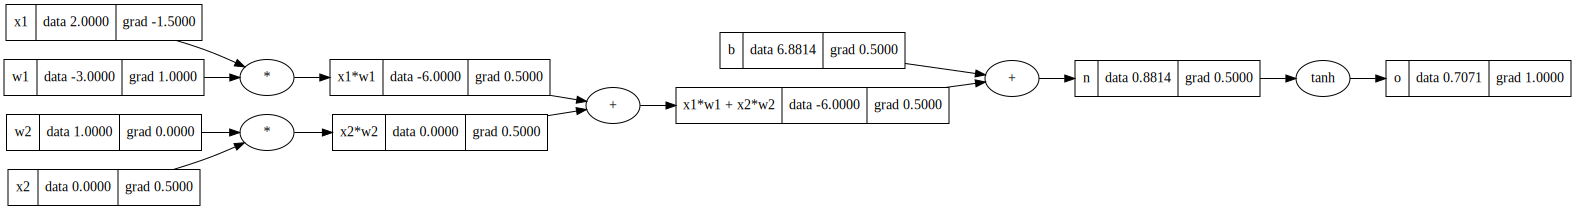

In [106]:
draw_dot(o)

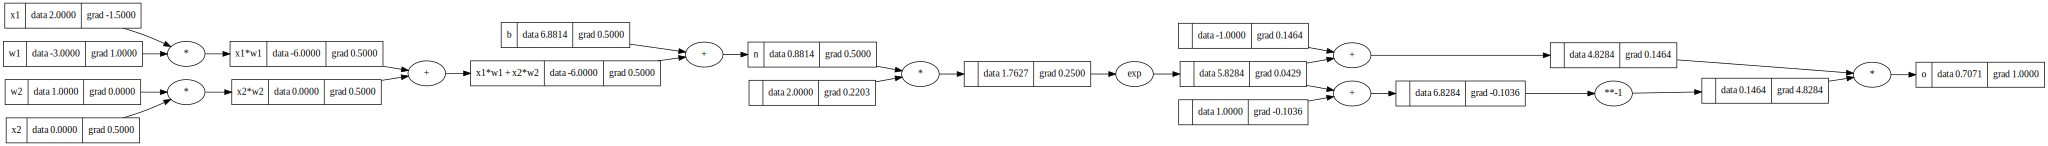

In [107]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

##### THERE IS A BUG IN THE ABOVE CODE (UNLESS WE FIX THE VALUE FRUNCTION, WE WANT TO COUNT THE ADDITIONS/MULTIPLICATION/USING A VARIABLE MORE TAHN ONCE IN THE BACKPROPAGATION, THIS IS ACCOUNTED FOR IN THE VALUE CLASS WITH THE "+=")

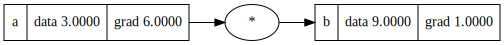

In [108]:
a = Value(3.0, label='a')
b = a * a   ; b.label = 'b'
b.backward()
draw_dot(b)

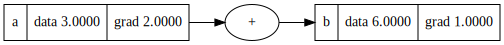

In [109]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

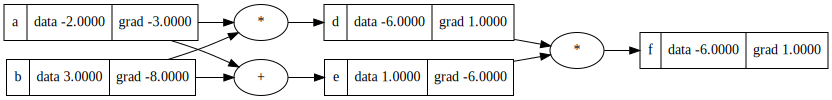

In [110]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

---------

### PYTORCH

A tensor is a generalization of scalars, vectors, and matrices to higher dimensions. In deep learning and libraries like PyTorch, a tensor is a multi-dimensional array (like a NumPy array) that can represent data of any shape—such as a single number (0D), a vector (1D), a matrix (2D), or higher-dimensional data (3D, 4D, etc.).
Tensors are the fundamental data structure for storing and manipulating data in neural networks. They support automatic differentiation and can be moved between CPU and GPU for efficient computation.

In [ ]:
# import torch


# # Create input tensors and set requires_grad=True to track gradients
# x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
# x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
# w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
# w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
# b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True

# # Compute the neuron output: n = x1*w1 + x2*w2 + b
# n = x1*w1 + x2*w2 + b

# # Apply the tanh activation function
# o = torch.tanh(n)

# # Print the output value
# print("forward pass - output",o.data.item())

# # Perform backpropagation to compute gradients
# o.backward()

# print('---')
# # Print gradients of each input/weight with respect to the output
# print('x2', x2.grad.item())
# print('w2', w2.grad.item())
# print('x1', x1.grad.item())
# print('w1', w1.grad.item())

forward pass - output 0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


##### Following is the implementation of NN using the value class above

In [113]:
import random

In [ ]:
class Neuron:
    """
    A single artificial neuron (node) for a neural network.

    This class represents a neuron that takes a fixed number of inputs,
    computes a weighted sum plus bias, and applies a tanh activation function.

    Attributes:
        w (list of Value): The list of weights for each input.
        b (Value): The bias term.
    """

    def __init__(self, nin):
        """
        Initialize the neuron with random weights and bias.

        Args:
            nin (int): Number of inputs to the neuron.
        """
        # Initialize weights with random values between -1 and 1
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        # Initialize bias with a random value between -1 and 1
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        """
        Compute the output of the neuron for a given input - this is done with n(x)

        Args:
            x (list of float or Value): Input values.

        Returns:
            Value: The output after applying weighted sum, bias, and tanh activation.
        """
        # Compute weighted sum of inputs plus bias: act = w1*x1 + w2*x2 + ... + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        # Apply tanh activation function
        out = act.tanh()
        return out

    def parameters(self):
        """
        Return all parameters (weights and bias) of the neuron.

        Returns:
            list of Value: All trainable parameters.
        """
        return self.w + [self.b]

In [135]:
x = [2.0, 3.0]      # Input vector with 2 features
n = Neuron(2)       # Create a neuron that expects 2 inputs

n(x)                # Forward pass: compute the output of the neuron

Value(data=-0.8077795127957147)

In [134]:
class Layer:
    """
    Represents a layer of neurons in a neural network.

    This class creates a layer consisting of multiple neurons, each with its own weights and bias.
    It supports forward computation (calling the layer with input) and provides access to all parameters.

    Attributes:
        neurons (list of Neuron): The list of neurons in this layer.
    """

    def __init__(self, nin, nout):
        """
        Initialize the layer with a given number of input and output neurons.

        Args:
            nin (int): Number of inputs to each neuron in the layer.
            nout (int): Number of neurons (outputs) in the layer.
        """
        # Create a list of nout neurons, each expecting nin inputs
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        """
        Compute the output of the layer for a given input.

        Args:
            x (list of float or Value): Input values.

        Returns:
            Value or list of Value: The output(s) from the layer.
        """
        # Forward pass: compute output of each neuron in the layer
        outs = [n(x) for n in self.neurons]
        # If only one neuron, return its output directly; else return list of outputs
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        """
        Return all parameters (weights and biases) of all neurons in the layer.

        Returns:
            list of Value: All trainable parameters in the layer.
        """
        # Flatten the list of parameters from all neurons
        return [p for neuron in self.neurons for p in neuron.parameters()]

In [138]:
# Example usage of the Layer class

x = [2.0, 3.0]        # Input vector with 2 features
n = Layer(2, 3)       # Create a layer with 2 inputs and 3 neurons (outputs)

n(x)                  # Forward pass: compute the outputs of the layer for input

[Value(data=-0.8598882563445465),
 Value(data=-0.9607774598364979),
 Value(data=-0.8433336025757586)]

In [ ]:
class MLP:
    """
    Multi-Layer Perceptron (MLP) neural network.

    This class constructs a feedforward neural network with a configurable number of layers and neurons per layer.
    Each layer is a fully connected Layer object. The network supports forward computation and parameter access.

    Args:
        nin (int): Number of input features.
        nouts (list of int): List specifying the number of neurons in each layer (output sizes).

    Attributes:
        layers (list of Layer): The list of layers in the network.
    """

    def __init__(self, nin, nouts):
        """
        Initialize the MLP with the given input size and list of output sizes for each layer.

        Args:
            nin (int): Number of input features.
            nouts (list of int): Output sizes for each layer.
        """
        sz = [nin] + nouts  # List of layer sizes (input + all outputs)
        # Create each layer: Layer(sz[i], sz[i+1]) for all layers -list of layers with sizes nin and nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))] 

    def __call__(self, x):
        """
        Perform a forward pass through the network.

        Args:
            x (list of float or Value): Input vector.

        Returns:
            Value or list of Value: The output of the network.
        """
        # Pass input through each layer in sequence
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        """
        Return all parameters (weights and biases) of the network.

        Returns:
            list of Value: All trainable parameters in the network.
        """
        # Flatten parameters from all layers
        return [p for layer in self.layers for p in layer.parameters()]

In [140]:
x = [2.0,3.0,-1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=0.36010143914455556)

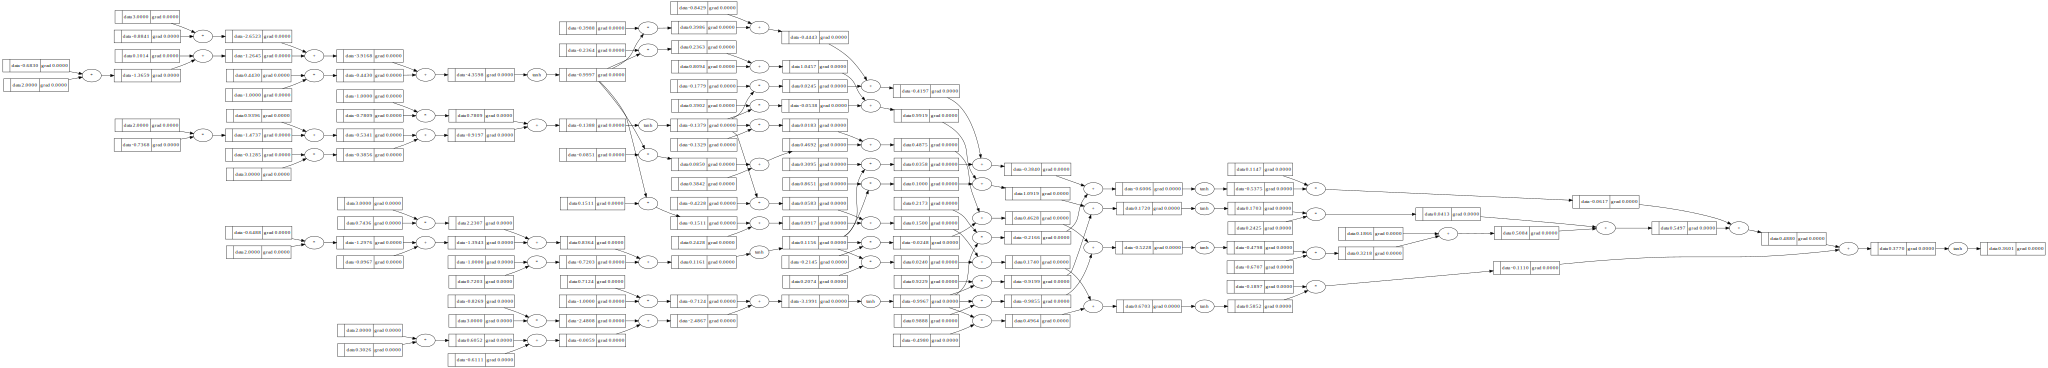

In [141]:
draw_dot(n(x))

In [142]:
# xs contains 4 input vectors, each with 3 features
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
# ys contains the target output for each input vector
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

# The model learns one weight per feature in that layer (plus a bias), and applies the same set to every row when computing outputs.
# For each input x in xs, compute the network's prediction
ypred = [n(x) for x in xs]
ypred

[Value(data=0.36010143914455556),
 Value(data=-0.32595213268254836),
 Value(data=0.3320468642564167),
 Value(data=0.3099353727005473)]

In [ ]:
# Calculate the total loss as the sum of squared errors between predicted and target values for all input samples - we want to minimize this loss, that would push the predictions closer to the targets

loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=3.114348734045359)

In [144]:
loss.backward()

In [ ]:
n.layers[0].neurons[0].w[0].grad 

-0.19851072112428805

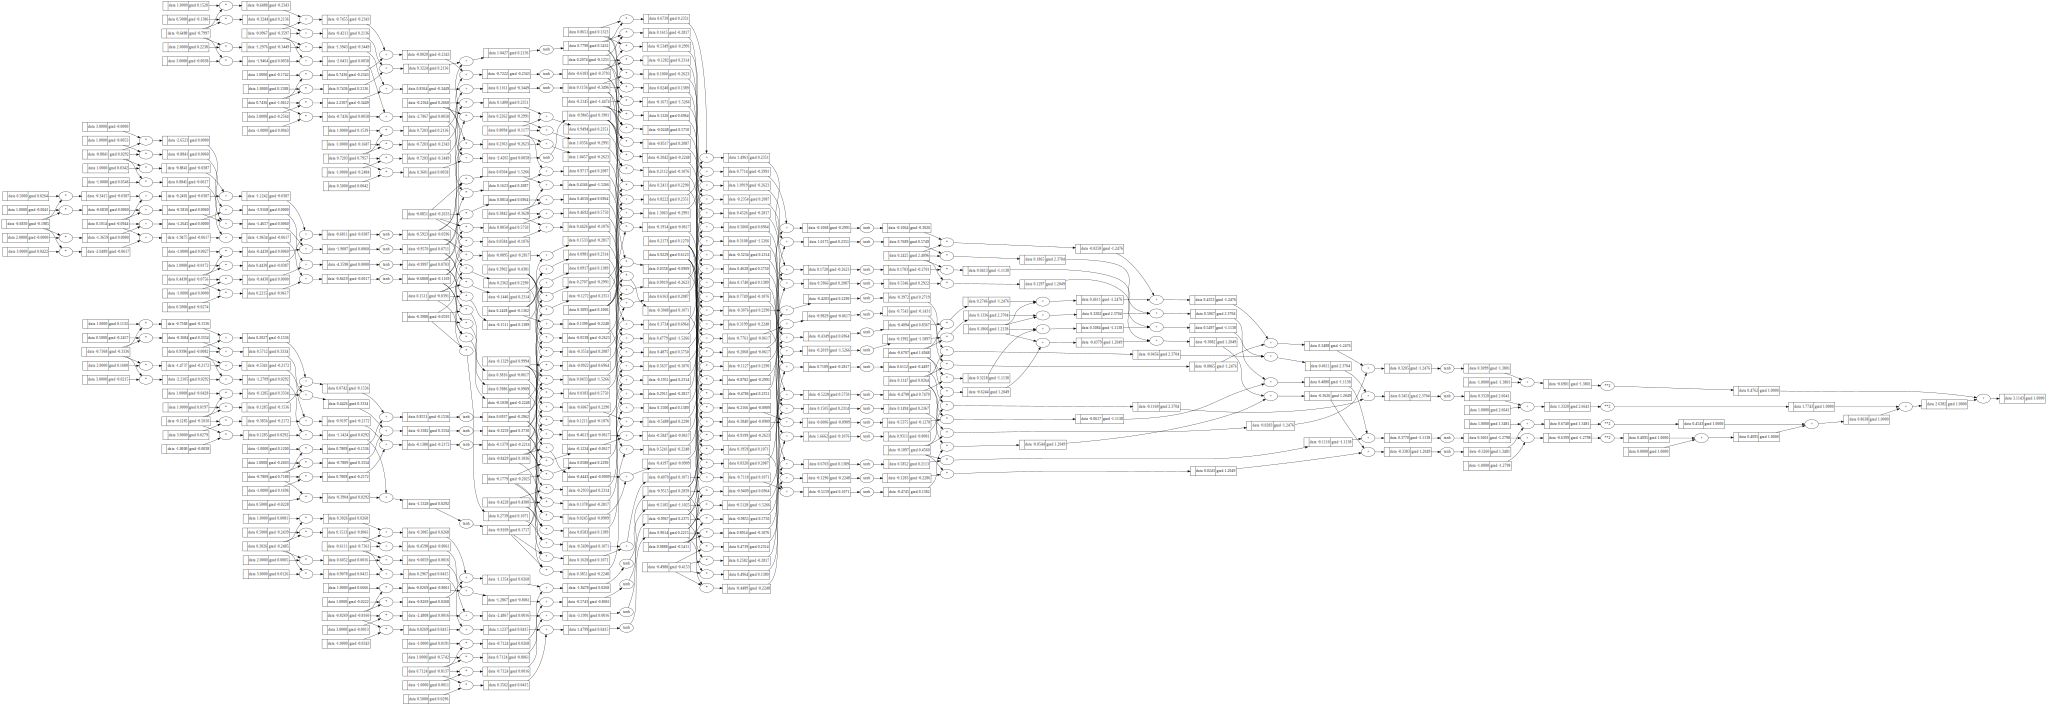

In [146]:
draw_dot(loss)

In [126]:
n.parameters()

[Value(data=0.03850500815866509),
 Value(data=0.910161907592282),
 Value(data=-0.9595333404051243),
 Value(data=-0.6179349796623976),
 Value(data=-0.3453334340481462),
 Value(data=0.5670914793768043),
 Value(data=0.18882718648886065),
 Value(data=0.5395382409816989),
 Value(data=-0.17728158853851883),
 Value(data=-0.09972309683574188),
 Value(data=-0.28289942828404024),
 Value(data=-0.08861466479920099),
 Value(data=0.30994741669735815),
 Value(data=-0.7826915722821461),
 Value(data=0.7782007433823706),
 Value(data=-0.32597941019527776),
 Value(data=-0.6931285426866962),
 Value(data=-0.42662109659376357),
 Value(data=0.47913642979505555),
 Value(data=0.9654957922758356),
 Value(data=-0.38383164522932933),
 Value(data=0.9592375665966235),
 Value(data=-0.6980496281126047),
 Value(data=0.6773476220065242),
 Value(data=0.532648076399123),
 Value(data=-0.4226186765535911),
 Value(data=0.8781123217502109),
 Value(data=0.48336767692489313),
 Value(data=0.10005574720807697),
 Value(data=0.7071

In [ ]:
for k in range(20):
  
  # ---- Forward pass: compute predictions and loss ----
  ypred = [n(x) for x in xs]  # Compute model predictions for all inputs
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # Sum of squared errors (loss)
  
  # ---- Backward pass: compute gradients ----
  for p in n.parameters():
    p.grad = 0.0  # Reset gradients to zero before backward pass
  loss.backward()  # Compute gradients of loss w.r.t. all parameters
  
  # ---- Update parameters using gradient descent ----
  for p in n.parameters():
    p.data += -0.1 * p.grad  # Update each parameter in the direction that reduces loss
  
  print(k, loss.data)  # Print epoch number

0 6.530714671031515
1 4.407250564019348
2 1.0032976131854747
3 0.14458149048278707
4 0.10166732327281075
5 0.07850808674829889
6 0.06384562311995505
7 0.05371435707959703
8 0.04629722697977954
9 0.04063626828714134
10 0.03617703205971159
11 0.03257602976496292
12 0.029609053013271228
13 0.02712353842251158
14 0.025012086083042395
15 0.023196917244586092
16 0.021620335853942494
17 0.020238651132518066
18 0.01901817957488493
19 0.017932541242787255


In [128]:
n.parameters()

[Value(data=0.01662389577443501),
 Value(data=0.9106472114874569),
 Value(data=-1.0347569257346652),
 Value(data=-0.6400569972478097),
 Value(data=-0.14856540765332163),
 Value(data=0.3736153586055199),
 Value(data=0.4024163778950348),
 Value(data=0.6085259059385898),
 Value(data=-0.19640791897957702),
 Value(data=0.2612451846509358),
 Value(data=-0.7055080417335542),
 Value(data=-0.1360436934918595),
 Value(data=0.23151890272280287),
 Value(data=-0.8516698913339431),
 Value(data=0.6799486935451883),
 Value(data=-0.42164001647098065),
 Value(data=-0.5584739494886855),
 Value(data=-0.465709185977767),
 Value(data=0.5893140886819208),
 Value(data=0.9142044766549268),
 Value(data=-0.5493427107683521),
 Value(data=1.1115543287515075),
 Value(data=-0.6073736896661166),
 Value(data=0.7478352508540778),
 Value(data=0.38210132262640156),
 Value(data=-0.3438377284967341),
 Value(data=0.8736633713325309),
 Value(data=0.4894742407418403),
 Value(data=0.1342965448738297),
 Value(data=0.69935254060